In [ ]:
df = pd.read_csv('pivoted_Ádánd.csv',decimal=',')
df=df[['timestamp','Levegőhőmérséklet','Relatív páratartalom','Talajhőmérséklet','Talajnedvesség']]
df.rename(columns={
    'Levegőhőmérséklet': 'air_temperature',
    'Relatív páratartalom': 'relative_humidity',
    'Talajhőmérséklet': 'soil_temperature',
    'Talajnedvesség': 'soil_moisture'
}, inplace=True)
df.dropna(inplace=True)
df['air_temperature'] = pd.to_numeric(df['air_temperature'])
df['relative_humidity'] = pd.to_numeric(df['relative_humidity'])
df['soil_temperature'] = pd.to_numeric(df['soil_temperature'])
df['soil_moisture'] = pd.to_numeric(df['soil_moisture'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.dtypes)
df.head()

In [8]:
# Define features and targets
features = df[['air_temperature', 'relative_humidity', 'soil_temperature', 'soil_moisture']]
targets = df[['air_temperature', 'relative_humidity', 'soil_temperature', 'soil_moisture']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_spl

/home/nephalem/.pyenv/versions/3.11.9/envs/w_predictenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
172 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nephalem/.pyenv/versions/3.11.9/envs/w_predictenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nephalem/.pyenv/versions/3.11.9/envs/w_predictenv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/nephalem/.pyenv/versions/3.11.9/envs/w_pred

Root Mean Squared Error for air_temperature: 0.7339047828242133
Root Mean Squared Error for relative_humidity: 1.803721213037128
Root Mean Squared Error for soil_temperature: 0.6661988467594147
Root Mean Squared Error for soil_moisture: 1.064103021779531


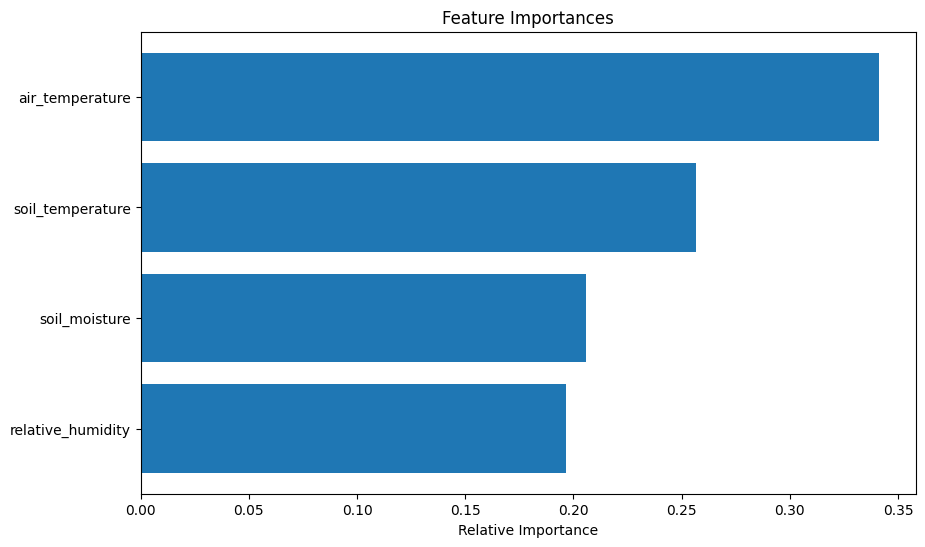

In [9]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred_scaled = best_model.predict(X_test_scaled)

# Inverse transform the predictions
y_pred = target_scaler.inverse_transform(y_pred_scaled)

# Evaluate the model for each target
mse = {}
rmse = {}
for i, col in enumerate(targets.columns):
    mse[col] = mean_squared_error(y_test[col], y_pred[:, i])
    rmse[col] = np.sqrt(mse[col])
    print(f"Root Mean Squared Error for {col}: {rmse[col]}")

# Feature importance
importances = best_model.feature_importances_
feature_names = features.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [10]:
# Save the model
joblib.dump(best_model, 'multi_output_weather_prediction_model.pkl')

# Load the model
model = joblib.load('multi_output_weather_prediction_model.pkl')
# Make predictions on new data
new_data = pd.DataFrame({
    'air_temperature': [15.88924577],
    'relative_humidity': [86.20211353],
    'soil_temperature': [19.08781824],
    'soil_moisture': [38.52994203]
})
new_data_scaled = scaler.transform(new_data)  # Ensure new_data is preprocessed similarly
predictions_scaled = model.predict(new_data_scaled)
predictions = target_scaler.inverse_transform(predictions_scaled)

print(predictions)


[[16.80020531 85.91358696 19.47222645 38.51801691]]
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_est